<a href="https://colab.research.google.com/github/mesbah-git/Optimizing-Energy-Efficiency/blob/main/Optimizing_Energy_Efficiency_with_Machine_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Office Room Occupancy Detection using Statistical Models**

### Introduction
The prediction of room occupancy has profound implications in various contexts, from optimizing energy efficiency in smart buildings and ensuring adequate ventilation in crowded public spaces, to enhancing security and comfort in smart homes. More than just conserving resources, accurately forecasting room occupancy is pivotal for creating safer, more sustainable, and adaptive environments. This becomes especially important given today's dynamic and rapidly-evolving technological landscape. The objective of this project is to predict a room's occupancy status by analyzing environmental factors such as CO2 levels, humidity, and lighting.

### Dataset
The training dataset comprises 8143 rows and 7 columns, while the test dataset contains 9752 rows and 7 columns. Both datasets were sourced from the [UCI machine learning repository](https://colab.research.google.com/corgiredirector?site=https%3A%2F%2Farchive.ics.uci.edu%2Fdataset%2F357%2Foccupancy%2Bdetection) [1]. The training data spans from 2015-02-04 to 2015-02-10, while the test data covers the period from 2015-02-11 to 2015-02-18. The datasets are stored in separate files to prevent potential data leakage. This dataset is licensed under the Creative Commons Attribution 4.0 International (CC BY 4.0) license, making it publicly accessible. The data was collected by monitoring an office room every minute to capture various environmental parameters and determine occupancy status.

The features in the dataset include:

1. Date and Time: Year-month-day and hour:minute:second
2. Temperature: Measured in degrees Celsius (°C)
3. Relative Humidity: Presented in percentages (%)
4. Light: Measured in Lux (LX)
5. CO2: Measured in parts per million (PPM)
6. Humidity Ratio: A derived quantity from temperature and relative humidity, expressed in kg(water-vapor)/kg-air
7. Occupancy: Binary value, with 0 representing 'not occupied' and 1 indicating 'occupied'.

#### Importing required libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from time import time
import warnings
warnings.filterwarnings('ignore')

#Sklearn related libraries
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,GradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV,GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn import tree
from sklearn.decomposition import PCA
from sklearn import metrics
from sklearn.utils.extmath import density
from sklearn.svm import SVC
%pip install xgboost
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

#Statistic Related libraries
from statsmodels.stats.outliers_influence import variance_inflation_factor as VIF

Defaulting to user installation because normal site-packages is not writeable
  Using cached xgboost-3.0.2-py3-none-win_amd64.whl.metadata (2.1 kB)
Using cached xgboost-3.0.2-py3-none-win_amd64.whl (150.0 MB)
Note: you may need to restart the kernel to use updated packages.


### Reading data:
In this section, I Load the data and attempt to extract significant features from it.

In [ ]:
url_trainig_data = 'https://raw.githubusercontent.com/mesbah-git/Optimizing-Energy-Efficiency/refs/heads/main/datatraining.txt'
occupancy_train=pd.read_csv(url_trainig_data)
display(occupancy_train.head(5))
occupancy_train.info()

,date,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
1,2015-02-04 17:51:00,23.18,27.2720,426.0,721.25,0.004793,1
2,2015-02-04 17:51:59,23.15,27.2675,429.5,714.00,0.004783,1
3,2015-02-04 17:53:00,23.15,27.2450,426.0,713.50,0.004779,1
4,2015-02-04 17:54:00,23.15,27.2000,426.0,708.25,0.004772,1
5,2015-02-04 17:55:00,23.10,27.2000,426.0,704.50,0.004757,1


<class 'pandas.core.frame.DataFrame'>
Index: 8143 entries, 1 to 8143
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           8143 non-null   object 
 1   Temperature    8143 non-null   float64
 2   Humidity       8143 non-null   float64
 3   Light          8143 non-null   float64
 4   CO2            8143 non-null   float64
 5   HumidityRatio  8143 non-null   float64
 6   Occupancy      8143 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 508.9+ KB


In [ ]:
#Getting the number of rows and columns in the dataset
occupancy_train.shape

(8143, 7)

In [ ]:
#Displaying dataset to see the extreme values and statistical values in each column
display(occupancy_train.describe().round(2))

,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
count,8143.00,8143.00,8143.00,8143.00,8143.00,8143.00
mean,20.62,25.73,119.52,606.55,0.00,0.21
std,1.02,5.53,194.76,314.32,0.00,0.41
min,19.00,16.74,0.00,412.75,0.00,0.00
25%,19.70,20.20,0.00,439.00,0.00,0.00
50%,20.39,26.22,0.00,453.50,0.00,0.00
75%,21.39,30.53,256.38,638.83,0.00,0.00
max,23.18,39.12,1546.33,2028.50,0.01,1.00


In [ ]:
#Getting the ratio of occupied/not_occupied in from the dataset
#From the above table I can extarct get this ratio
#21.0 percent of the dataset are occupied records, and 79% of them are not-occupied

base_line_error=(sum(occupancy_train["Occupancy"]==1)/occupancy_train.shape[0])*100
print("The baseline error on the training set in this classification problem is {:.2f}%".format(base_line_error))

The baseline error on the training set in this classification problem is 21.23%


If I split the data into training and test sets, this ratio should be preserved (which I'll verify before proceeding to the modeling phase). So, I expect this ratio to be reflected in this test set. If accuracy is the chosen metric, the baseline/null accuracy in this case is approximately 78%. Therefore, it's crucial to develop a model that achieves accuracy on the test dataset surpassing this value.

#### Checking null values:

In [ ]:
occupancy_train.isnull().sum()

date             0
Temperature      0
Humidity         0
Light            0
CO2              0
HumidityRatio    0
Occupancy        0
dtype: int64

#### Checking duplicate values:

In [ ]:
duplicates = occupancy_train[occupancy_train.duplicated(keep=False)]
print('Duplicate values in the Dataset=', duplicates)

Duplicate values in the Dataset= Empty DataFrame
Columns: [date, Temperature, Humidity, Light, CO2, HumidityRatio, Occupancy]
Index: []


There are no missing/duplicate values in the columns. This may be attributed to the fact that the data was consistently collected by sensors, which significantly reduces the likelihood of encountering missing/duplicate values.

#### Changing the format of the date column from object to datetime

In [ ]:
occupancy_train['date']=occupancy_train['date'].astype('datetime64[ns]')
occupancy_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8143 entries, 1 to 8143
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   date           8143 non-null   datetime64[ns]
 1   Temperature    8143 non-null   float64       
 2   Humidity       8143 non-null   float64       
 3   Light          8143 non-null   float64       
 4   CO2            8143 non-null   float64       
 5   HumidityRatio  8143 non-null   float64       
 6   Occupancy      8143 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 508.9 KB


#### Creating box-plots to identify outliers visually

The first 6 columns, ranging from 'Date' to 'Humidity Ratio', serve as features, while the 'Occupancy' column is the response variable. Given that I am not conducting Time Series Analysis at this stage and classification based on time isn't considered logical, I can exclude the 'Date' column and retain the other features. Additionally, I will only perform EDA on the training data. I suppose that I do not have any infromation about the test set until the prediction phase.

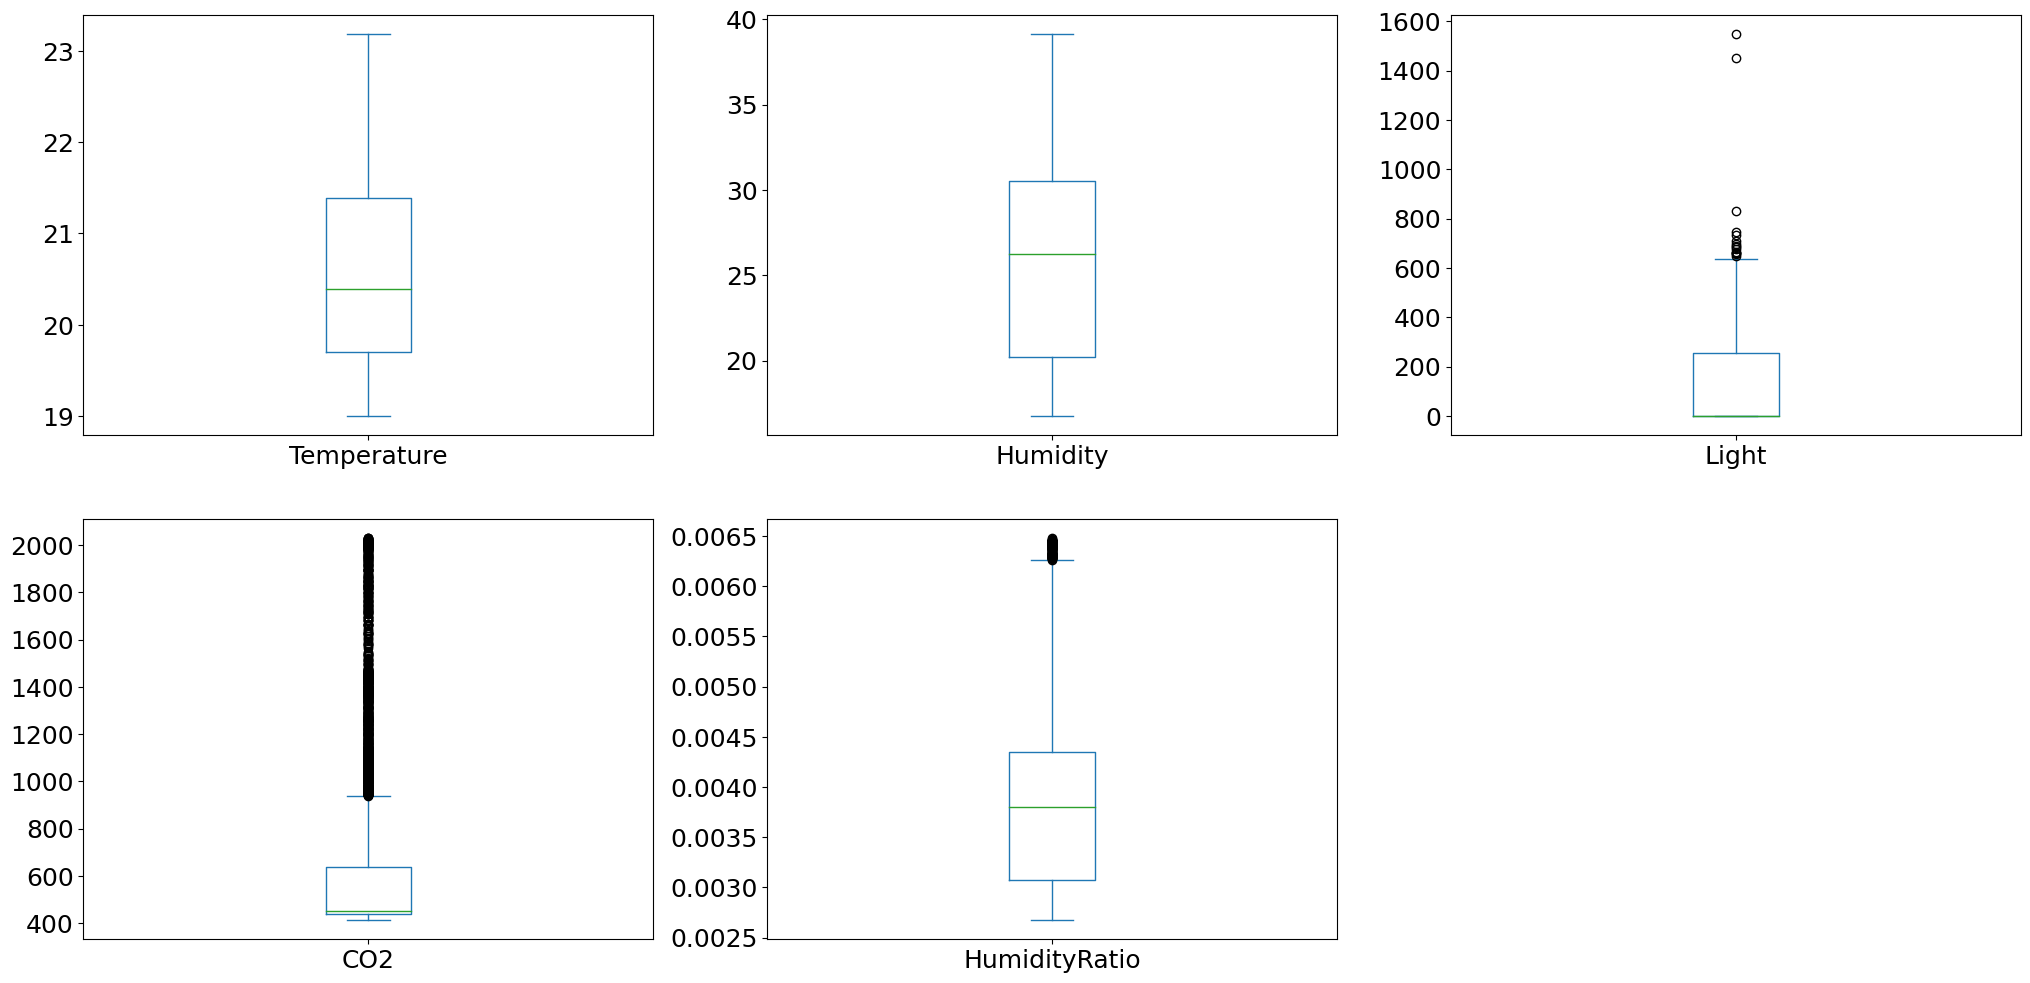

In [ ]:
#filtering training dataset based on features except date
features=occupancy_train.iloc[:,1:6]
plt.rcParams['figure.figsize']=(25,12)
features.plot(kind='box',  subplots=True, layout=(2,3), sharex=False, sharey=False, fontsize=18 )
plt.show()

Based on the plots above, I can identify outliers in the 'Light', 'CO2', and 'Humidity Ratio' columns. I have two methods to handle these: either by removing them or by standardizing the features. The latter preserves the data. I didn't consider outliers for the 'Temperature' column as the range of values appears reasonable. Therefore, it's crucial to standardize data prior to using distance-based methodologies.

I can also define outliers as data points that fall beyond Q3+3*IQR. Subsequently, I will calculate the total number of points exceeding this value in the training dataset.

In [ ]:
def num_outliers(df,col):
  q1=df[col].quantile(0.25)
  q3=df[col].quantile(0.75)
  IQR=q3-q1
  #Based on Tuckey's method
  #probable outlier is located outside the outer fence
  upper_outer_fence=q3 + 3*IQR
  outlier_array_indexes=np.where(df[col]>=upper_outer_fence)[0]
  return outlier_array_indexes.shape[0]

print(f"The number of outliers in CO2 column based on the Tuckey's method is {num_outliers(occupancy_train,'CO2')}")
print(f"The number of outliers in Light column based on the Tuckey's method is {num_outliers(occupancy_train,'Light')}")
print(f"The number of outliers in Temperature column based on the Tuckey's method is {num_outliers(occupancy_train,'Temperature')}")
print(f"The number of outliers in Humidity column based on the Tuckey's method is {num_outliers(occupancy_train,'Humidity')}")
print(f"The number of outliers in Humidity Ratio column based on the Tuckey's method is {num_outliers(occupancy_train,'HumidityRatio')}")

The number of outliers in CO2 column based on the Tuckey's method is 452
The number of outliers in Light column based on the Tuckey's method is 2
The number of outliers in Temperature column based on the Tuckey's method is 0
The number of outliers in Humidity column based on the Tuckey's method is 0
The number of outliers in Humidity Ratio column based on the Tuckey's method is 0


The above results suggest that it is better to standardize the data before employing any distance-based methods, such as Logistic Regression, SVC, or KNN Classifier.

#### What does the distribution of features look like?
Before any preprocessing, it's worthwhile to examine the histograms of the features. This provides a better understanding of how to handle these features.

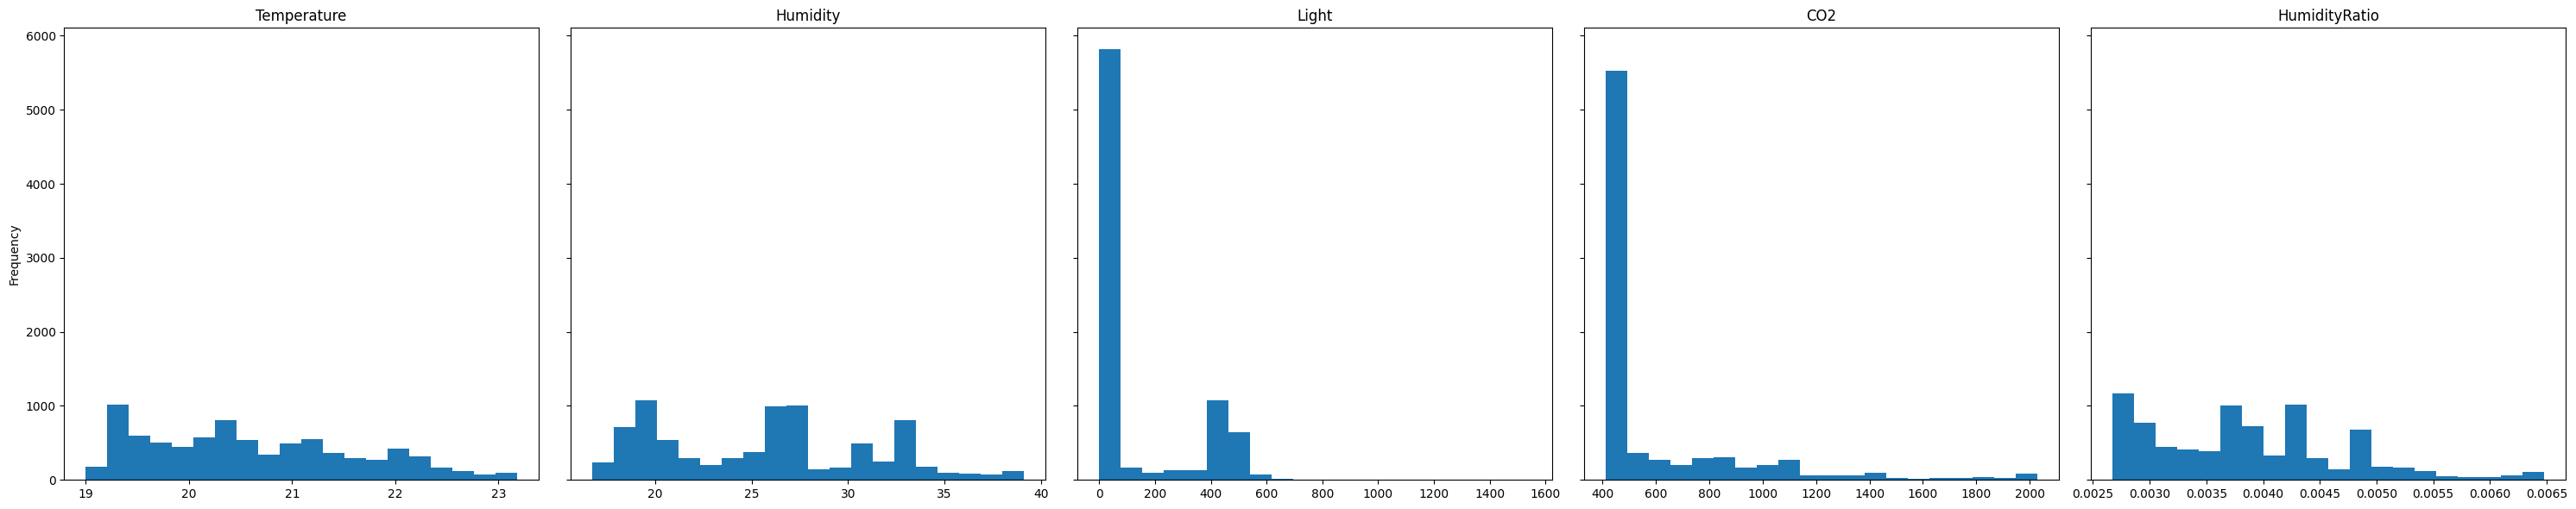

In [ ]:
fig, axs = plt.subplots(1, 5, sharey=True, tight_layout=True,figsize=(30,6))
for i,feature in enumerate(features):
  dist=occupancy_train[feature]
  axs[i].hist(dist,bins=20)
  axs[i].set_title(feature)

axs[0].set_ylabel('Frequency')
plt.show()

From the above distribution plots, I can conclude that none of the features are normally distributed. However, the 'Temperature', 'Light', 'CO2', and 'Humidity Ratio' features exhibit right-skewed.

#### Different scalers that can be used in this project

The range of values in the 'CO2' and 'Light' columns is greater than zero. If I use the Standard Scaler, it could result in negative values. However, if I opt for the Min-Max Scaler, all the transformed values will fall between zero and one. Regarding the PCA method, I should use the Standard Scaler as the data must be centered before any transformation.



#### Correlation Matrix to identify Multicollinearity between features

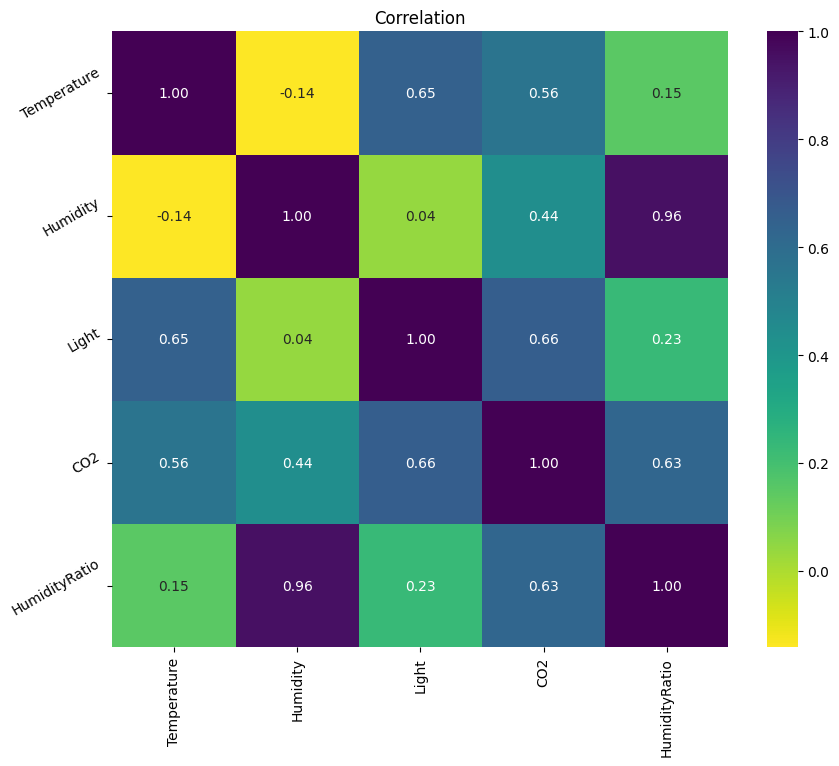

In [ ]:
features_corr=features.corr()

plt.figure(figsize=(10, 8))
plt.title('Correlation')
a = sns.heatmap(features_corr, square=True, annot=True, fmt='.2f', linecolor='white', cmap='viridis_r')
a.set_xticklabels(a.get_xticklabels(), rotation=90)
a.set_yticklabels(a.get_yticklabels(), rotation=30)
plt.show()

From the above plot and the corresponding pearson correlations between the features, I observed that there is a high positive correlation between light and temperature (0.65), CO2 and light(0.66), CO2 and Humidity(0.44), Temperature and CO2 (0.56), and Humidity and Humidity ratio (0.96).

In [ ]:
VIF_dataframe=pd.DataFrame()
VIF_dataframe['features']=features.columns
VIF_dataframe['VIF']=[VIF(features.values,i) for i in range(features.columns.shape[0])]
VIF_dataframe

,features,VIF
0,Temperature,22.896769
1,Humidity,538.779235
2,Light,3.031914
3,CO2,18.722682
4,HumidityRatio,692.832601


The VIF test was conducted to evaluate the multicollinearity between the features. The result shows that it exists in this dataframe. The best solution for this issue is the Principle Component Analysis to reduce the dimentionality and, most importantly, producing uncorrelated features in order to have more stable ML models.

### Preprocessing and Modeling

In [ ]:
#Reading the test data from repository
url_test_data='https://raw.githubusercontent.com/mesbah-git/Optimizing-Energy-Efficiency/refs/heads/main/datatest.txt'
occupancy_test=pd.read_csv(url_test_data)

##Features and Response variables of the train set
features_train=occupancy_train.iloc[:,1:6]
response_train=occupancy_train['Occupancy']

##Features and Response variables of the test set
features_test=occupancy_test.iloc[:,1:6]
response_test=occupancy_test['Occupancy']

X_train=np.array(features_train).reshape(-1,features_train.columns.shape[0])
X_test=np.array(features_test).reshape(-1,features_test.columns.shape[0])

y_train=np.array(response_train).reshape(-1)
y_test=np.array(response_test).reshape(-1)

#Calculating the test-dataset base-line accuracy
test_set_baseline_accuracy=(y_test[y_test==0].shape[0])/(y_test.shape[0])*100
print("The baseline accuracy of the test set is {:.2f}%".format(test_set_baseline_accuracy))


The baseline accuracy of the test set is 78.99%


### Logistic Regression

In [ ]:
scaler = StandardScaler() # Create an instance of Standard Scaler

X_train_logreg = scaler.fit_transform(X_train) # Fit the scaler on the training data
X_test_logreg = scaler.transform(X_test) # Standardize the testing data

# Initialize and Fit the logistic regression model
logreg = LogisticRegression()
logreg.fit(X_train_logreg, y_train)

# Make predictions on the test data
y_test_pred = logreg.predict(X_test_logreg)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_test_pred)
print(f"Accuracy on test data: {accuracy*100:.3f}%")

Accuracy on test data: 98.493%


### Optimize the Logistic Regression parameters with cross-validation

In [ ]:
# Set the hyperparameters to test
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
              'penalty': ['10','l1','l2']}

logreg = LogisticRegression() # Initialize the logistic regression model

# Initialize and fit the Grid Search model
grid_search = GridSearchCV(logreg, param_grid, cv=5) # cv=5 defines the number of folds in cross-validation
grid_search.fit(X_train_logreg, y_train)

# Get the best parameters
best_params = grid_search.best_params_
print(f"Best parameters: {best_params}")

# Now use the best parameters to create a new Logistic Regression model
optimized_logreg = LogisticRegression(**best_params)
optimized_logreg.fit(X_train_logreg, y_train) # Fit the model with the optimized hyperparameters
y_test_pred = optimized_logreg.predict(X_test_logreg) # Predict on the test data

accuracy = accuracy_score(y_test, y_test_pred)
print(f"Accuracy on test data: {accuracy*100:.3f}%")

Best parameters: {'C': 0.1, 'penalty': 'l2'}
Accuracy on test data: 99.282%


### Lasso Classifier and Determining Important Features

Lasso Classifier Accuracy: 98.48


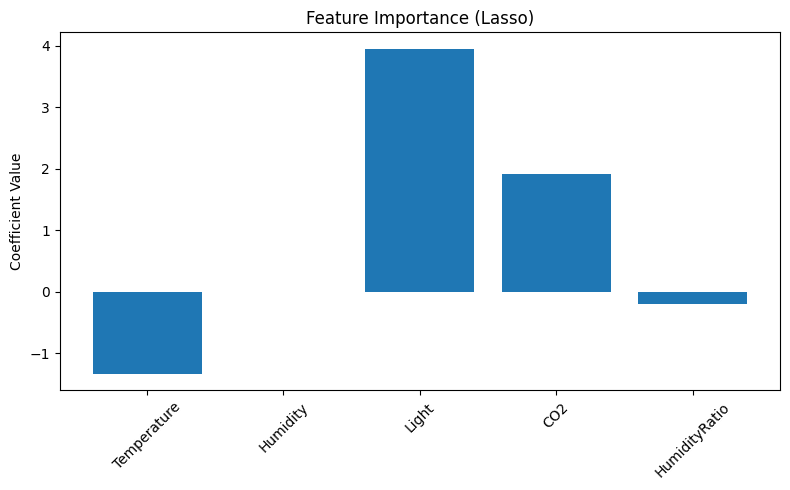

In [ ]:
# Training the Logistic Regression model with L1 penalty
lasso_classifier = LogisticRegression(penalty='l1', solver='liblinear', max_iter=5000)
lasso_classifier.fit(X_train_logreg, y_train)
y_pred = lasso_classifier.predict(X_test_logreg)

accuracy = accuracy_score(y_test, y_pred)
print(f"Lasso Classifier Accuracy: {accuracy*100:.2f}")

# Extracting the coefficients
coefs = lasso_classifier.coef_

# Plotting the important features
plt.figure(figsize=(8, 5))
plt.bar(features_train.columns, coefs[0])
plt.xticks(rotation=45)
plt.ylabel('Coefficient Value')
plt.title('Feature Importance (Lasso)')
plt.tight_layout()
plt.show()

### KNN Classifier

In [ ]:
# Scaling the data, necessary for KNN as a distance-based method
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

knn = KNeighborsClassifier(n_neighbors=5) # Create a KNN classifier instance (let's say, I choose k = 5)

# Train the model with the training data
knn.fit(X_train, y_train)

# Predict the labels for the test data
y_pred = knn.predict(X_test)

# Validate the classifier using the accuracy score
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy:{:.2f}%'.format(accuracy*100))

Accuracy:93.33%


#### Optimize the KNN Classifier with cross-validation

In [ ]:
# Scaling the data, necessary for KNN
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Create a KNN classifier instance
knn = KNeighborsClassifier()

# Define the parameter values that should be searched
k_range = list(range(1, 31,2)) # search for the optimal k between 1 and 30
param_grid = dict(n_neighbors=k_range)

# GridSearchCV
grid = GridSearchCV(knn, param_grid, cv=10, scoring='accuracy')
grid.fit(X_train, y_train)
y_pred = grid.predict(X_test) # Predict the labels for the test data using the model with 25 neighbors

# Examine the best model
print('Accuracy:{:.2f}%'.format(grid.best_score_*100))
print('The best found number of neighbors:', grid.best_estimator_)

Accuracy:95.05%
The best found number of neighbors: KNeighborsClassifier(n_neighbors=25)


### Support Vector Classifier (SVC)

In [ ]:
#Finding best Hyper-parameter
param_grid = {
    'C': [0.1, 1, 10, 100]
}
grid_search = GridSearchCV(SVC(), param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)

display(grid_search.best_params_)

#Train the SVC model
svc_model = grid_search.best_estimator_

svc_model.fit(X_train, y_train)

y_pred = svc_model.predict(X_test)

# Calculate and print the accuracy of the classifier
accuracy = accuracy_score(y_test, y_pred)
print("Final Accuracy {:.2f}%".format(accuracy*100))

{'C': 1}

Final Accuracy 95.31%


Here, without standerdization of data and dimentioanlity reduction I am able to achieve 95.31% accuracy.

Now, let's try to standardize the X features and train the model again. As I have some outliers for some of the features so Standard Scaler is the best choice

In [ ]:
#Standardize the training set
scaler = StandardScaler()
X_train_standardized = scaler.fit_transform(X_train)

#Standardize the test set (using mean and std from training set)
X_test_standardized = scaler.transform(X_test)

#Finding best Hyper-parameter
param_grid = {'C': [0.01, 0.1, 1, 10, 100]}
grid_search = GridSearchCV(SVC(), param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train_standardized, y_train)

display(grid_search.best_params_)

#Train the SVC model
svc_model = grid_search.best_estimator_
svc_model.fit(X_train_standardized, y_train)

#Evaluate the model
y_pred = svc_model.predict(X_test_standardized)
accuracy = accuracy_score(y_test, y_pred)
print("Final Accuracy {:.2f}%".format(accuracy*100))


{'C': 1}

Final Accuracy 95.31%


Interestingly, after applying standardization the accuracy is reduced!

In the next section, let's try to tune all the hyper parameters with standardize data

In [ ]:
scaler = StandardScaler()
X_train_standardized = scaler.fit_transform(X_train)

#Standardize the test set (using mean and std from training set)
X_test_standardized = scaler.transform(X_test)

#Finding best Hyper-parameter
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': [0.01, 0.1, 1, 10],
    'kernel': ['linear', 'rbf']
}
grid_search = GridSearchCV(SVC(), param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train_standardized, y_train)
display(grid_search.best_params_)

#Train the SVC model
svc_model = grid_search.best_estimator_
svc_model.fit(X_train_standardized, y_train)

#Evaluate the model
y_pred = svc_model.predict(X_test_standardized)
accuracy = accuracy_score(y_test, y_pred)
print("Final Accuracy {:.2f}%".format(accuracy*100))


{'C': 100, 'gamma': 0.01, 'kernel': 'linear'}

Final Accuracy 99.19%


Previously I have noticed that some of the features are strongly co-related. So, let's try to reduce dimntionality using PCA and rebuild the model again.

In [ ]:
#Standardize the transformed data
scaler = StandardScaler()
X_train_standardized = scaler.fit_transform(X_train)
X_test_standardized = scaler.transform(X_test)

#Apply PCA
num_components = 4
pca = PCA(n_components=num_components)
X_train_pca = pca.fit_transform(X_train_standardized)
X_test_pca = pca.transform(X_test_standardized)

#Finding best Hyper-parameter
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': [0.01, 0.1, 1, 10],
    'kernel': ['linear', 'rbf']
}

grid_search = GridSearchCV(SVC(), param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train_standardized, y_train)
display(grid_search.best_params_)

#Train the SVC model
svc_model = grid_search.best_estimator_
svc_model.fit(X_train_pca, y_train)

# Evaluate the model
y_pred = svc_model.predict(X_test_pca)
accuracy = accuracy_score(y_test, y_pred)
print("Final Accuracy {:.2f}%".format(accuracy*100))



{'C': 100, 'gamma': 0.01, 'kernel': 'linear'}

Final Accuracy 99.24%


So, when I applied PCA on standardize data it showed a little improvement in the accuracy.

### Naive Bayes Classifiers (Family)

In [ ]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report

# Train the Gaussian Naive Bayes model
nb_model = GaussianNB()
nb_model.fit(X_train, y_train)

# Make predictions
y_pred = nb_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Final Accuracy {:.2f}%".format(accuracy*100))



Final Accuracy 98.76%


without normalization I am able to get 98.76% accuracy. Let's try to standardize the data and create the model again in the next section.

In [ ]:
# #Apply PCA
num_components = 4
pca = PCA(n_components=num_components)
X_train_pca = pca.fit_transform(X_train_standardized)
X_test_pca = pca.transform(X_test_standardized)

# Train the Gaussian Naive Bayes model
nb_model = GaussianNB()
nb_model.fit(X_train_pca, y_train)

# Make predictions
y_pred = nb_model.predict(X_test_pca)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Final Accuracy {:.2f}%".format(accuracy*100))


Final Accuracy 90.62%


Surprisingly, after standardization the accuracy is reduced significantly.

Next, let's try with Complement Naive Bayes model

In [ ]:
from sklearn.naive_bayes import ComplementNB

# Create and train the ComplementNB model
complement_nb_model = ComplementNB()
complement_nb_model.fit(X_train, y_train)

# Make predictions
y_pred = complement_nb_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Final Accuracy {:.2f}%".format(accuracy*100))


Final Accuracy 94.00%


In [ ]:
from sklearn.preprocessing import MinMaxScaler #fixed import

#Apply PCA
num_components = 4
pca = PCA(n_components=num_components)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

scaler = MinMaxScaler()
X_train_stan = scaler.fit_transform(X_train_pca)
X_test_stan = scaler.transform(X_test_pca)

# Create and train the ComplementNB model
complement_nb_model = ComplementNB()
complement_nb_model.fit(X_train_stan, y_train)

# Make predictions
y_pred = complement_nb_model.predict(X_test_stan)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Final Accuracy {:.2f}%".format(accuracy*100))


Final Accuracy 75.53%


Since I fit some transformation to X_train and X_test in the distance_based method, I can read the data again to avoid any errors in the calcualtion

In [ ]:
#Reading the test data from repository
url_test_data = 'https://raw.githubusercontent.com/mesbah-git/Optimizing-Energy-Efficiency/refs/heads/main/datatest.txt'
occupancy_test=pd.read_csv(url_test_data)

##Features and Response variables of the train set
features_train=occupancy_train.iloc[:,1:6]
response_train=occupancy_train['Occupancy']

##Features and Response variables of the test set
features_test=occupancy_test.iloc[:,1:6]
response_test=occupancy_test['Occupancy']

X_train=np.array(features_train).reshape(-1,features_train.columns.shape[0])
X_test=np.array(features_test).reshape(-1,features_test.columns.shape[0])

y_train=np.array(response_train).reshape(-1)
y_test=np.array(response_test).reshape(-1)

#Calculating the test-dataset base-line accuracy
test_set_baseline_accuracy=(y_test[y_test==0].shape[0])/(y_test.shape[0])*100
print("The baseline accuracy of the test set is {:.2f}%".format(test_set_baseline_accuracy))

The baseline accuracy of the test set is 78.99%


### Decision Tree Classifier
In this section, I created a simple decision tree model for classification. For a single Decision Tree, there are hyperparameters to be tuned. Five parameters are criterion,max_features, max_depth, min_sample_split, and min_sample_leaf. The description of these parameters is available at https://scikit-learn.org/

stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html. For example, to avoid overfitting, and maintain a balance between bias and variance I am limiting the tree depth. Also, the default of splitter is the best splitter, so I do not change it in this model. Grid Search Cross Validation is fitted on the training data to find the best parameters among all the possible combinations of parameters.

In [ ]:
dt_model=DecisionTreeClassifier(random_state=100)
dt_params={
    'criterion':("gini", "entropy", "log_loss"),
    'max_features':("sqrt", "log2",None),
    'min_samples_split':[2,4,6,8],
    'min_samples_leaf':[1,3,5,7,9],
    'max_depth':[5,6,7,8,9]

}
dt_search=GridSearchCV(estimator=dt_model,param_grid=dt_params)
best_dt_model=dt_search.fit(X_train,y_train)

In [ ]:
print("The best hyperparameters for DecisionTreeClassifier is:\n",best_dt_model.best_params_)

The best hyperparameters for DecisionTreeClassifier is:
 {'criterion': 'entropy', 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 3, 'min_samples_split': 8}


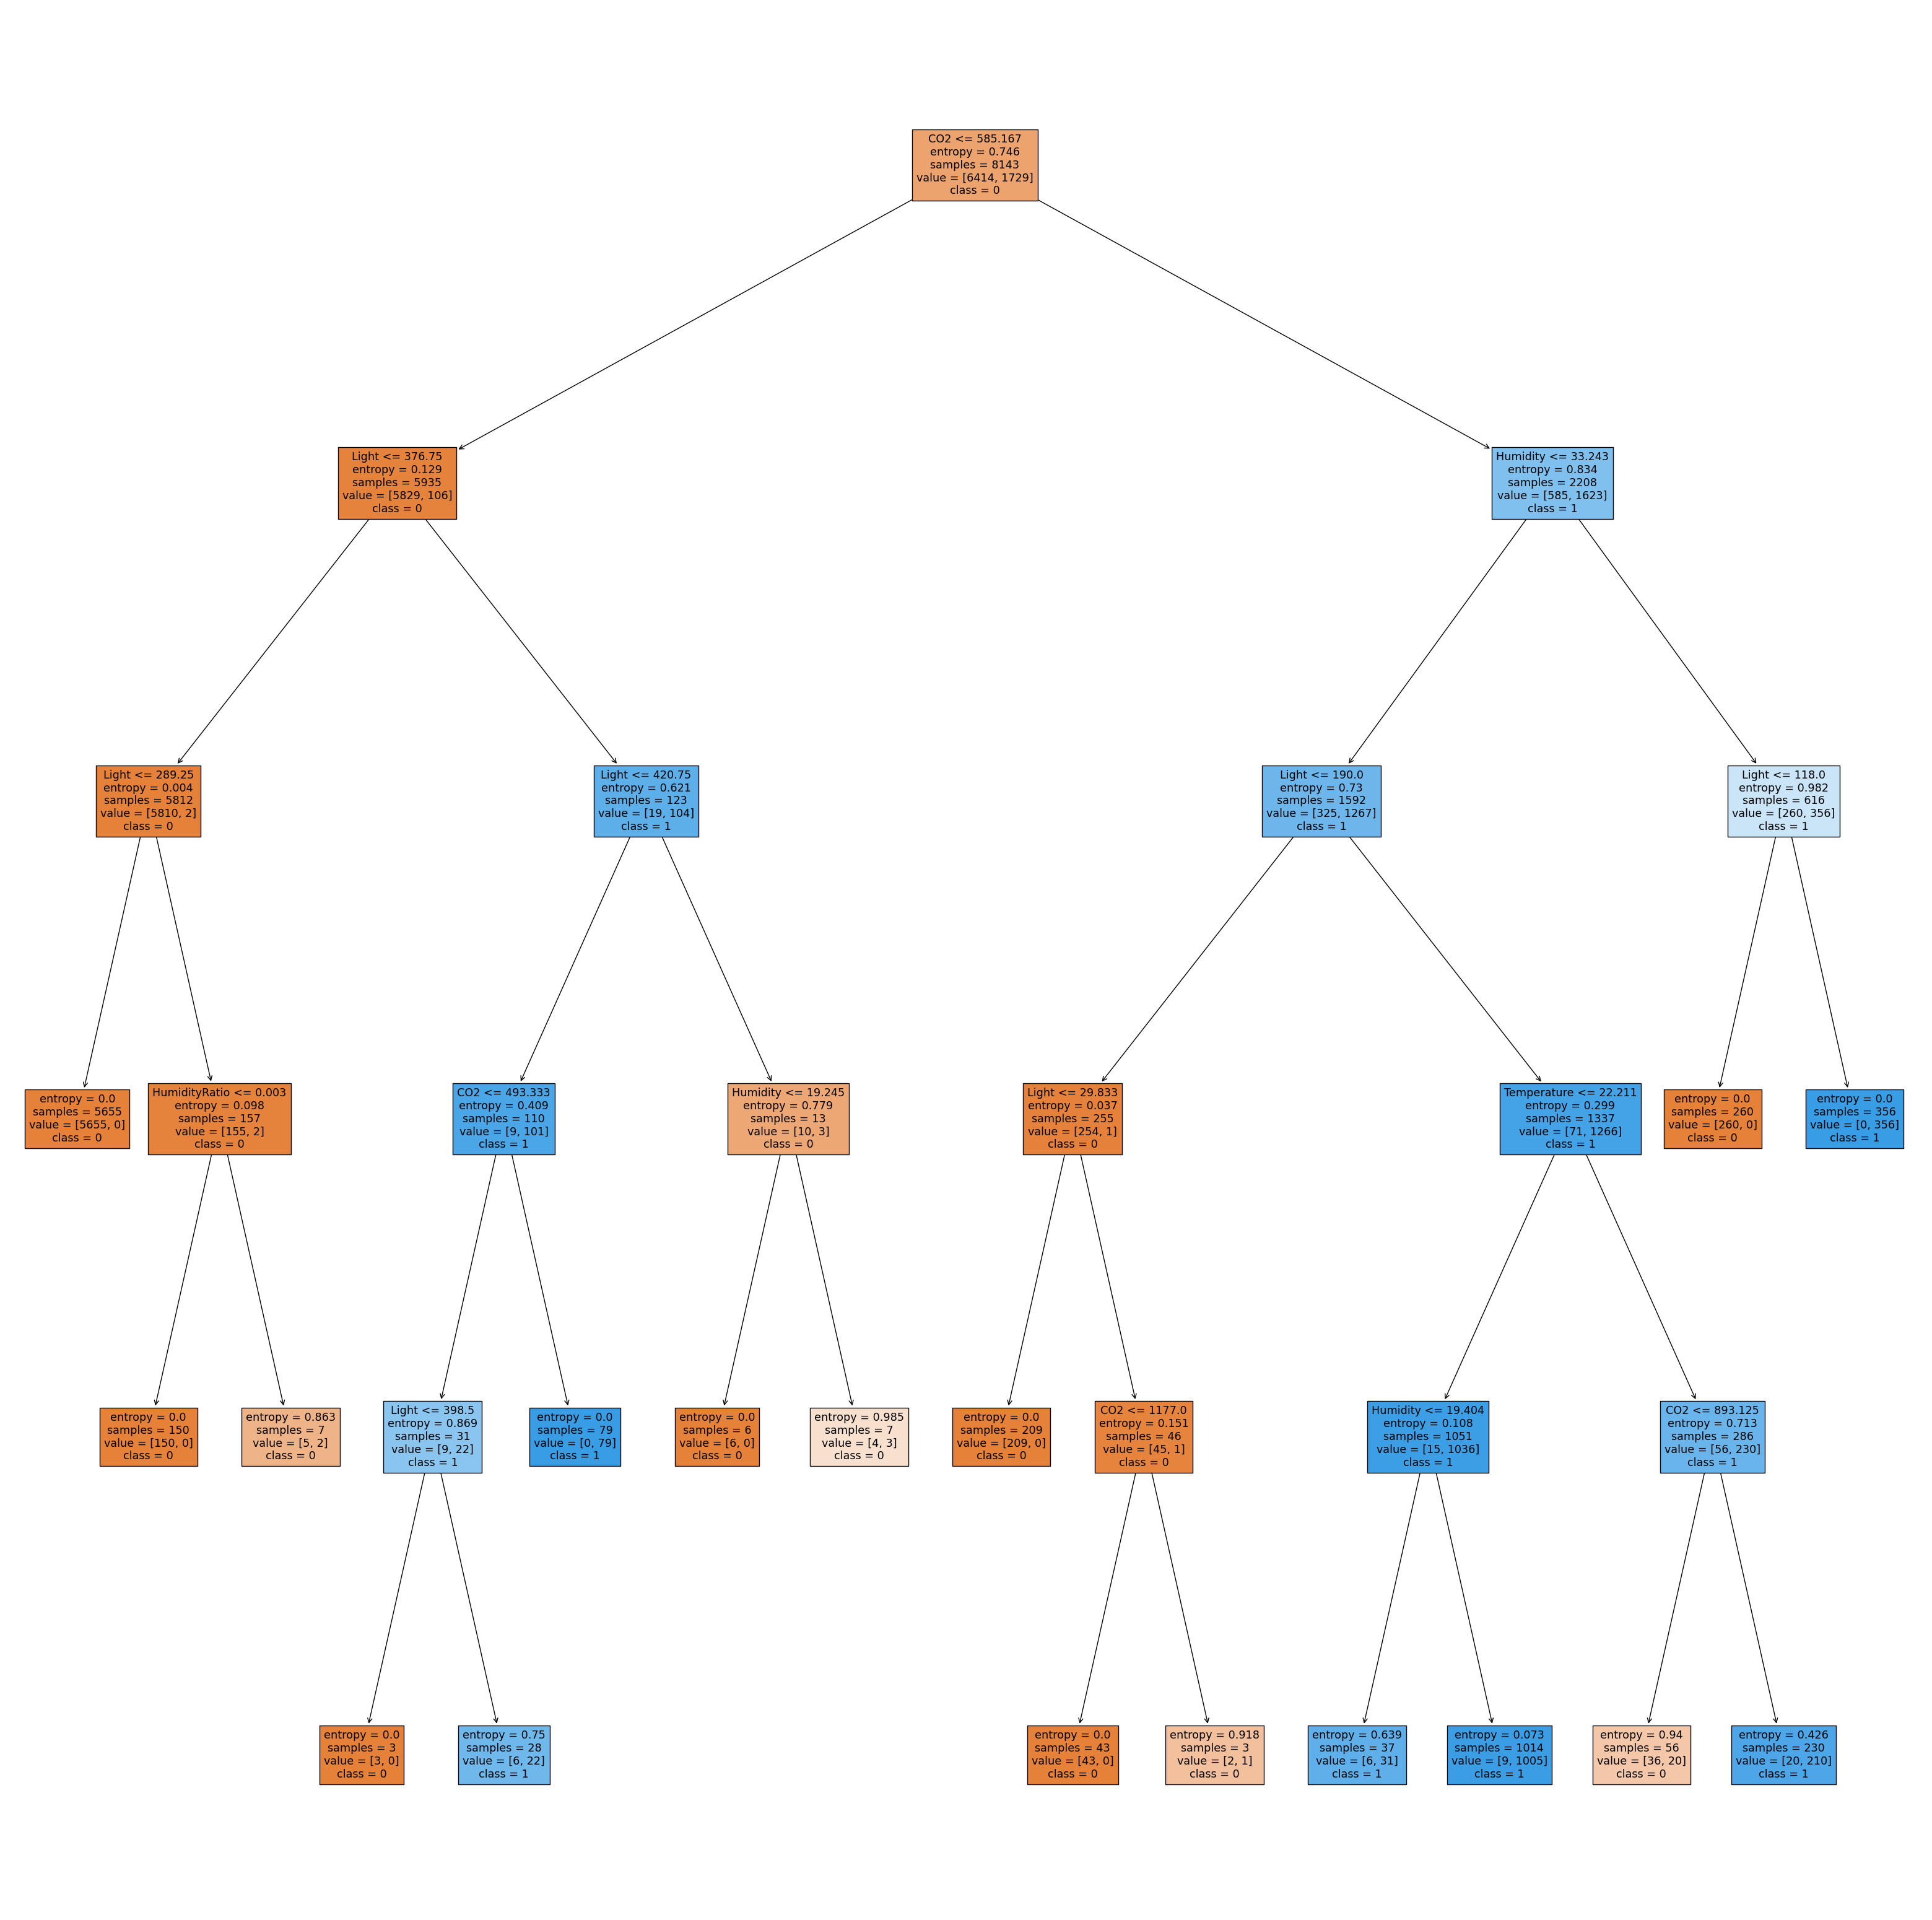

In [ ]:
#The best parameters are chosen based on the above results
final_dt_model=DecisionTreeClassifier(criterion='entropy',
                                     max_features='sqrt',
                                     min_samples_leaf=3,
                                     min_samples_split=8,
                                     max_depth=5,
                                     random_state=100
                                     )
final_dt_model.fit(X_train,y_train)
plt.figure(figsize=(40, 40))
tree.plot_tree(final_dt_model, feature_names=features.columns, class_names=['0', '1'], filled=True)
plt.show()

In [ ]:
dt_pred=final_dt_model.predict(X_test)
dt_acc=accuracy_score(y_test,dt_pred)*100
print("The Accuracy of Decision Tree Model on test data is {:.2f}%".format(dt_acc))

The Accuracy of Decision Tree Model on test data is 94.11%


Comments on the accuracy: This accuracy on the test set for a single tree is considered as a good accuracy and it seems that the tree-based models work pretty well with this dataset. I did not perform any preprocessing on the data before using this model. So, it shows how powerful tree-based models are. On the other hand, it is robust to outliers.
Additionally, In the context of smart homes, when someone wants to create a device based on data, it should be precise and produce high-accuracy results, otherwise if the product has errors even slightly, then it will lose many customers. So, It is important to have high accuracy to make sure that any device that estimates the occupancy works well.
As I look at the internal nodes, I observe that all the features play role in splitting and the final tree (after cross validation) uses all of the features. Since I do not have any pre-assumptions for the decision tree classifiers, all the features without any preprocessing exist in the model and it seems robust to outliers.

### Ensemble Techniques

### Bagging

#### Random Forest

In [ ]:
#In this part I am going to implement bagging techniques by using random forest
#I also use GridSearch cv to find the best hyperparameters.
rf_clf=RandomForestClassifier(n_jobs=2)

rf_params={
     'max_depth':[7,8,9,10],  #This information is gained after buliding a single decision tree
     'n_estimators':[100,200],
     'criterion': ['gini', 'entropy', 'log_loss'],
     'max_features': ['sqrt', 'log2', None],
     'oob_score':[True,False]  # I want to see if the metric of out-of-bag=True accuracy will have the best model
}

rf_clf_best=GridSearchCV(rf_clf,param_grid=rf_params)

#rf_clf_best.fit(X_train,y_train)

RandomForestClassifier(max_depth=7, n_jobs=2)

In [ ]:
rf_clf_best.best_params_

{'criterion': 'gini',
 'max_depth': 7,
 'max_features': 'sqrt',
 'n_estimators': 100,
 'oob_score': False}

The criterion that the 'information Gain' is calculted is 'gini' index. The max_depth of trees is limited to 7 and the sqrt(features) will be candidates for each split. maximum number of trees are 100 and the out_of_bag_score is set to False. So, the metric would be the mean accuracy of training set by after doing cross validation.

In [ ]:
#Since running the above code take a considerable amount of time, I created the new model based on that
rf_clf=RandomForestClassifier(
    n_jobs=2,
    criterion= 'gini',
    max_depth=7,
    max_features='sqrt',
    oob_score=False,
    n_estimators=100,
    )
#rf_clf.fit(X_train,y_train)

In [ ]:
score_list=[]
for i in range(1,100):
  rf_clf.fit(X_train,y_train)
  rf_pred=rf_clf.predict(X_test)
  score=accuracy_score(y_test,rf_pred)*100
  score_list.append(score)

ave_accuracy=sum(score_list)/len(score_list)

print("The Accuracy of the Random Forrest Model on test data is by average {:.2f}%".format(ave_accuracy))

The Accuracy of the Random Forrest Model on test data is by average 96.95%


Random Forrest is making a decision tree classifier more flexible. The result shows a significant improvement of the test set accuracy than a single decision tree classifier. Since each time the model is fitted on the train set, a random set of tress are created. It maeans that each time I predict and get the accuracy the value is different. I can set a random_state for this model, or I can create 100 models and get the average accuracy of these 100 models. This number will give us a good estimate on the goodness of the fit of random forrest on the test data. it is roughly 97%, that is much higher than a single tree.

#### Feature importances with a forest of trees
Now, I am going to extract the most important features of all the trees in the forest to see which features are more important.

The important fearures are:

Temperature      0.113103
Humidity         0.023493
Light            0.549939
CO2              0.283564
HumidityRatio    0.029901
dtype: float64


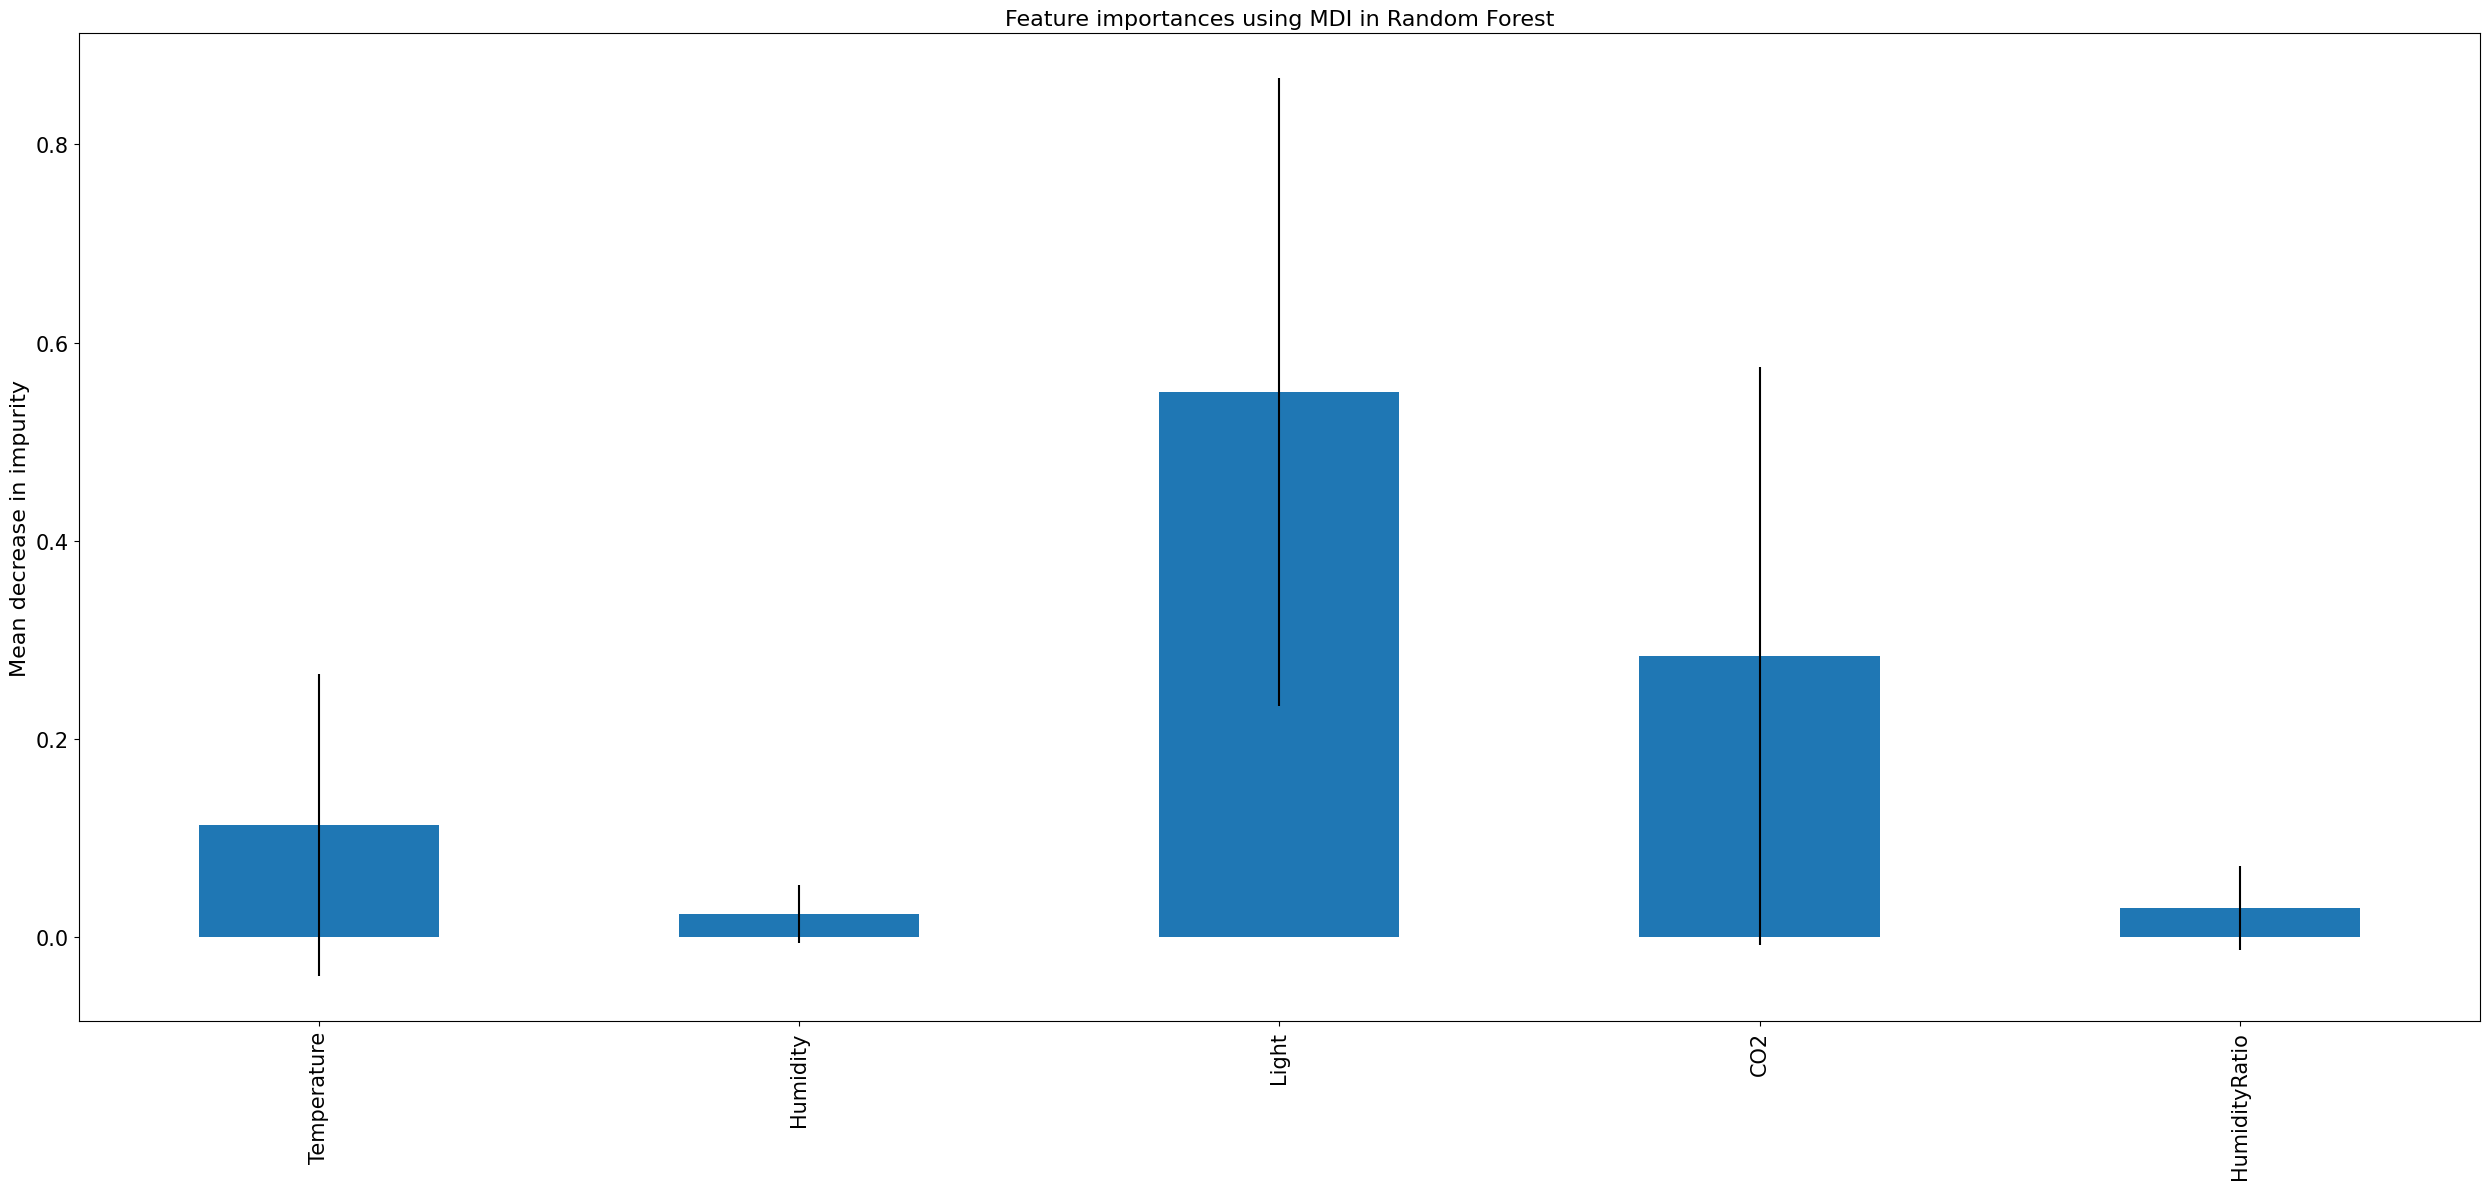

In [ ]:
importances = rf_clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf_clf.estimators_], axis=0)

feature_names = features_train.columns

forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI in Random Forest",fontsize=16)
ax.set_ylabel("Mean decrease in impurity",fontsize=16)
ax.tick_params(axis='x', labelsize=15)
ax.tick_params(axis='y', labelsize=15)
fig.tight_layout()

print("The important fearures are:\n")
print(forest_importances)

Based on the above plot, Light, CO2, and Temperature are three main important features used to create a forest of trees. They have the highest share in decreasing impurities when building trees in each forest. Both mean and the std for each feature are plotted.

### Boosting


#### AdaBoost

In [ ]:
Ada_clf=AdaBoostClassifier(
    learning_rate=0.01, #This parameter is changed since smaller learning rates will decrease the difference between two sequential weak learners.
                      #So, it is expected to have a more accurate final model
)
Ada_clf.fit(X_train,y_train)

AdaBoostClassifier(learning_rate=0.01)

In [ ]:
Ada_pred=Ada_clf.predict(X_test)
Ada_acc=accuracy_score(y_test,Ada_pred)*100
print("The Accuracy of the AdaBoost Model on test data is {:.2f}%".format(Ada_acc))

The Accuracy of the AdaBoost Model on test data is 99.31%


The AdaBoost model takes advantage of using stumps. Each stump has an 'amount to say' when the final prediction is evaluated. It means that each stump will use one of the features and then classify the samples. At this stage, the 'amount to say' is created based on the classification error, and for the next stump, the weight of the misclassified samples is higher. Finally, the classification will be based on the voting of all stumps, but the higher the 'amount to say' of a stump, the more weight its vote carries. In the context of this data, for each stump and feature, let's say Light, the misclassified samples are identified and will appear in the next stump. So, with each step, I take a significant stride towards training the dataset better.

Feature importance in AdaBoost Model Containing Stumps

The important features are:

Temperature      0.0
Humidity         0.0
Light            1.0
CO2              0.0
HumidityRatio    0.0
dtype: float64


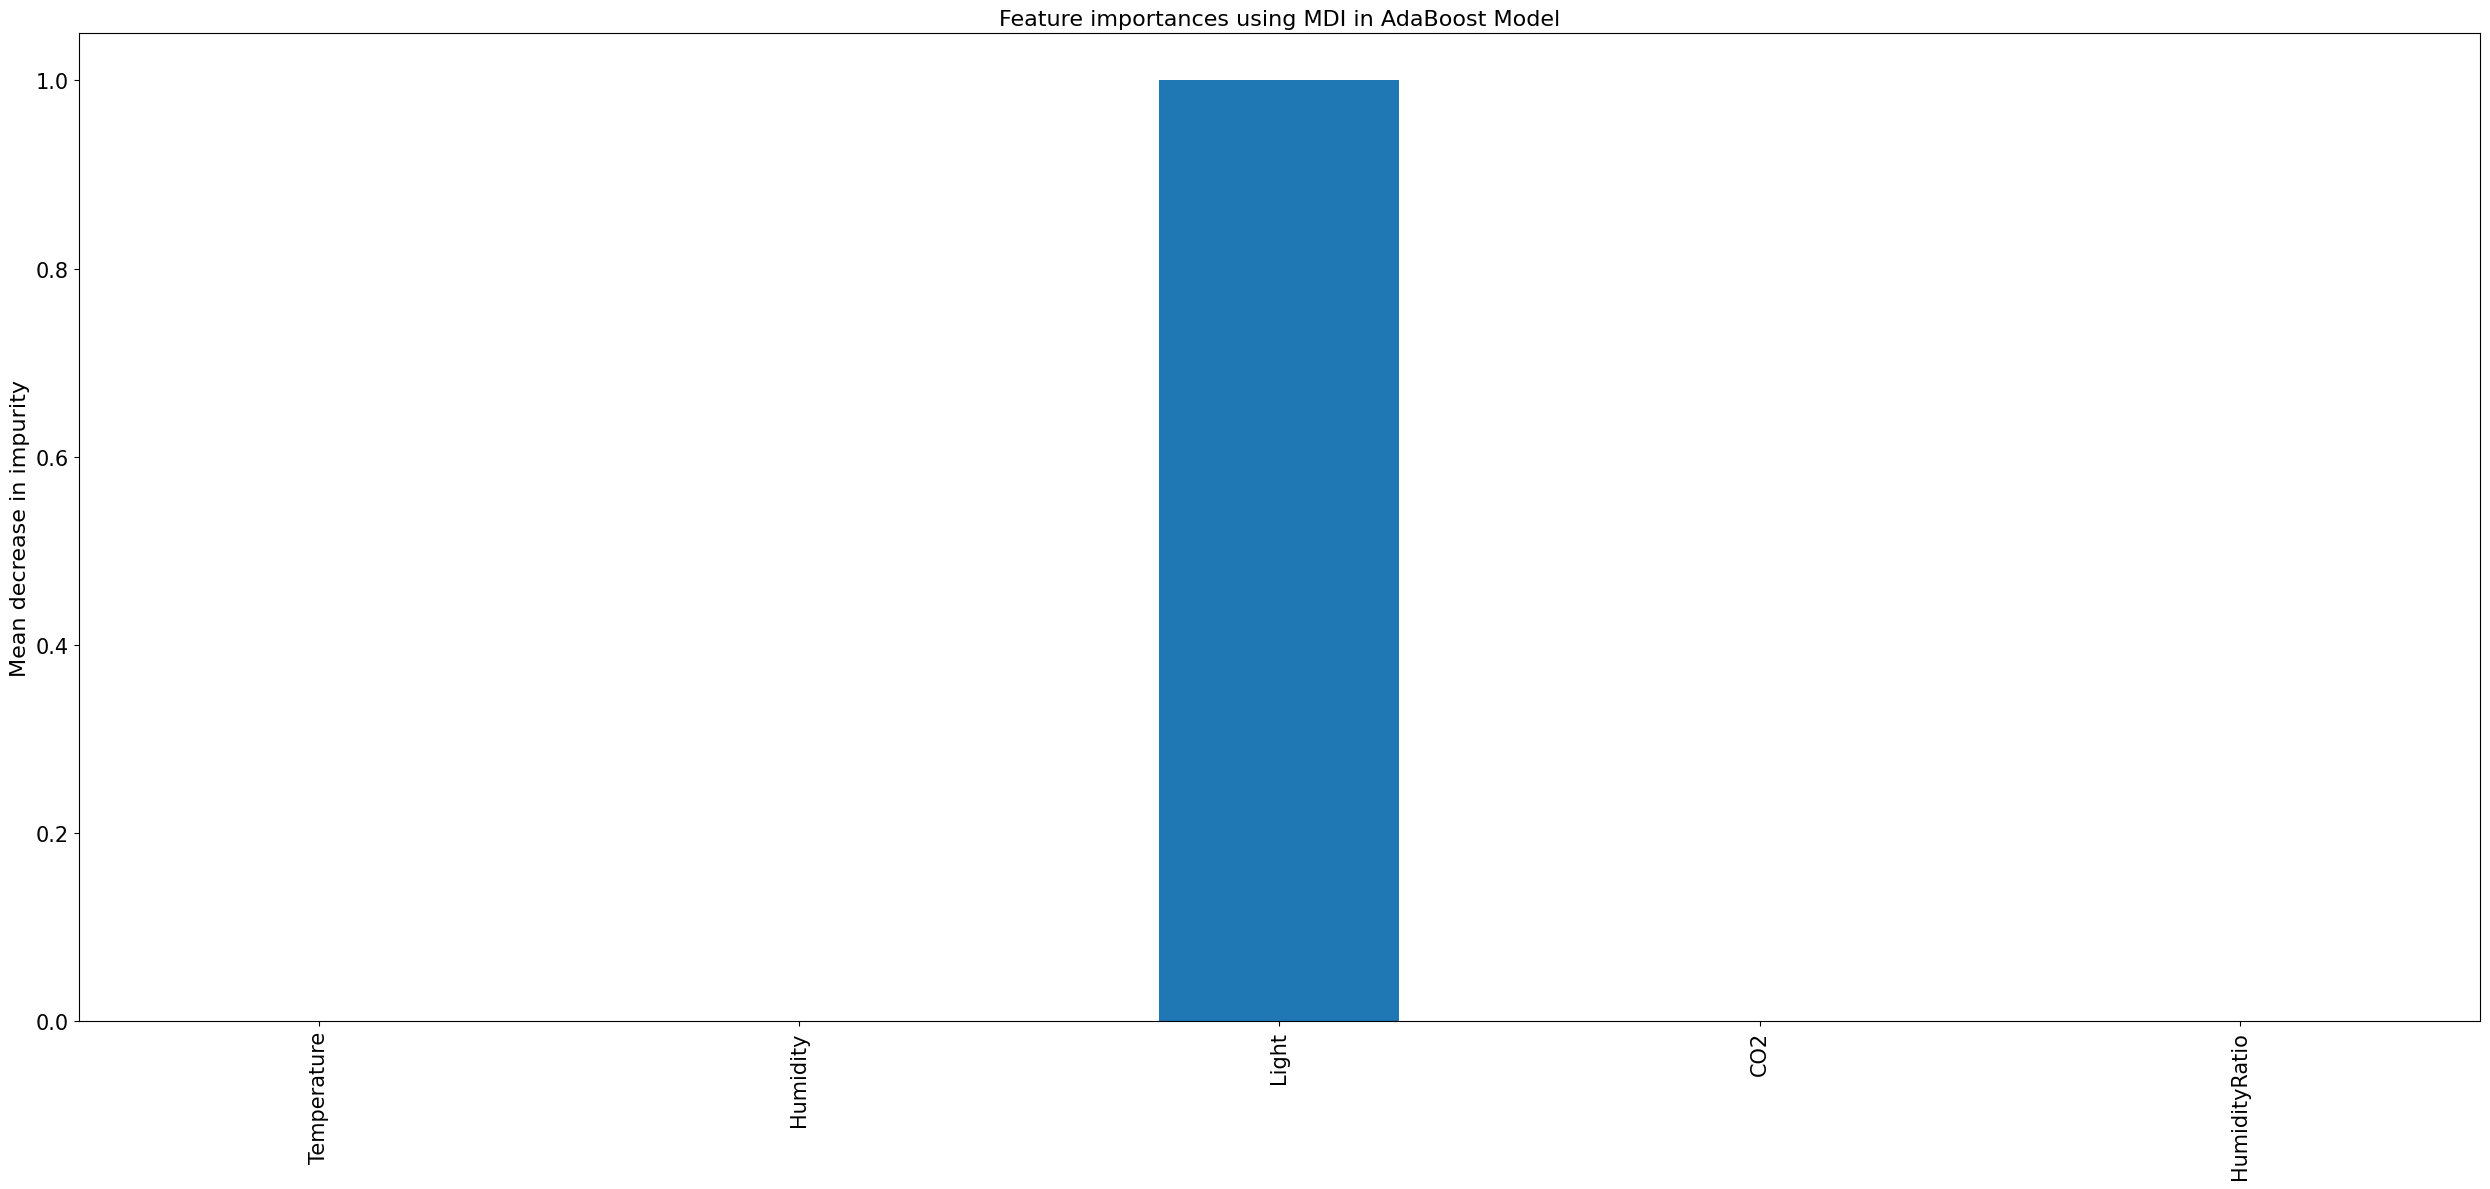

In [ ]:
importances = Ada_clf.feature_importances_
sd = np.std([tree.feature_importances_ for tree in Ada_clf.estimators_], axis=0)


feature_names = features_train.columns

Ada_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots()
Ada_importances.plot.bar(yerr=sd, ax=ax)
ax.set_title("Feature importances using MDI in AdaBoost Model",fontsize=16)
ax.set_ylabel("Mean decrease in impurity",fontsize=16)
ax.tick_params(axis='x', labelsize=15)
ax.tick_params(axis='y', labelsize=15)
fig.tight_layout()

print("The important features are:\n")
print(Ada_importances)

Unlike the random forest classifier, the only important feature here is light. It means that based on different threshhold of lights, all the stumps can be trained so that there is no need to the information of other features. By common sence, when the lights are on in an office room, it is more probable that it's occupied.

#### Gradient Boost Classifier

In [ ]:
GBoost_model=GradientBoostingClassifier()
GBoost_params={
    'loss':['log_loss', 'exponential'],
    'learning_rate':[0.01,0.1],
    'ccp_alpha':[0,0.5,1],
    'n_estimators':[200]
}
GB_search=GridSearchCV(estimator=GBoost_model,param_grid=GBoost_params)
GB_best_model=GB_search.fit(X_train,y_train)
print("The result of tuning is:")
GB_best_model.best_params_

The result of tuning is:


{'ccp_alpha': 0,
 'learning_rate': 0.01,
 'loss': 'exponential',
 'n_estimators': 200}

As the above attempt to find the best parameters for the gradient boost, I did not change some default hyperparameters like max_depth, subsample, min_samples_split, and min_sample_leaf. The default for these parameters seems quite reasonable for the model. For example, for the subsample, the default is one, and I want to build each weak learner based on the whole sample. The other interesting change is the loss function, that the exponential performs better than the loss function on the training data.

In [ ]:
GB_pred=GB_best_model.predict(X_test)
GB_acc=accuracy_score(y_test,GB_pred)*100
print("The Accuracy of the Gradient Boost Classifier on test data is {:.2f}%".format(GB_acc))

The Accuracy of the Gradient Boost Classifier on test data is 96.37%


The above result relative to the Adaboost model shows a  decrease in test data accuracy. However, the imporvement of the result depend on the number of weak learners. Graident boost is robust to overfitting so I can increase the number of trees to 200.

#### XGboost Classifier
As the final model in the boosting section, I am going to use Xtreme Gradient Boost which is a modified version of Gradient Boost and brings new definitions like regularization parameter (lambda) and cover. The regularization parameter reduce the sensitivity of a tree to individual observations by pruning and combining them with other observations.    

In [ ]:
XGB_model=XGBClassifier()
XGB_params={
    'eta':[0.01, 0.1,0.3],
    'gamma':[0.0,0.05,0.1],
    'max_depth':[6,7,8],
    'min_child_weight':[0,1],
    'lambda':[0,0.5,1],

}
XGB_search=GridSearchCV(estimator=XGB_model,param_grid=XGB_params)
XGB_best_model=XGB_search.fit(X_train,y_train)
print("The result of tuning is:")
XGB_best_model.best_params_

The result of tuning is:


{'eta': 0.01,
 'gamma': 0.0,
 'lambda': 0.5,
 'max_depth': 7,
 'min_child_weight': 1}

In [ ]:
XGB_pred=XGB_best_model.predict(X_test)
XGB_acc=accuracy_score(y_test,XGB_pred)*100
print("The Accuracy of the XGB Classifier on test data is {:.2f}%".format(XGB_acc))

The Accuracy of the XGB Classifier on test data is 96.45%


The result of the XGboost classifier on the test set shows a slight improvement to the regular gradient boost. Comparing the result of gradient boost and extreme gradient boost to the Adaboost, I can pick the Adaboost model as the best model among all ensemble models.

Now, I am going to compare the top three models which are Logistic Regression, Support Vector Classifier, and the AdaBoost. This comparison is based on training time, test time, and the accuracy. For the distance-based methods, It also prints the dimensionality which is the number of coefficients or better to say the number of features and their density, which represents the weights assigned to each predictor to calculate the log-odds of the binary outcome.
The function below is directly sourced from https://scikit-learn.org/stable/auto_examples/text/plot_document_classification_20newsgroups.html#sphx-glr-auto-examples-text-plot-document-classification-20newsgroups-py and it evaluates the accuracy and processing time for fitting and predicting with the model, as well as the accuracy of the classification model on the test set.

In [ ]:
def benchmark(clf, custom_name=False):
    print("_" * 80)
    print("Training: ")
    print(clf)
    t0 = time()
    clf.fit(X_train, y_train)
    train_time = time() - t0
    print(f"train time: {train_time:.3}s")

    t0 = time()
    pred = clf.predict(X_test)
    test_time = time() - t0
    print(f"test time:  {test_time:.3}s")

    score = metrics.accuracy_score(y_test, pred)
    print(f"accuracy:   {score:.3}")

    if hasattr(clf, "coef_"):
        print(f"dimensionality: {clf.coef_.shape[1]}")
        print(f"density: {density(clf.coef_)}")
        print()

    print()
    if custom_name:
        clf_descr = str(custom_name)
    else:
        clf_descr = clf.__class__.__name__
    #return clf_descr, score, train_time, test_time

In [ ]:
results = []
for clf, name in (
    (LogisticRegression(C=0.1, penalty='l2'), "Logistic Regression"),
    (SVC(C=100, kernel= 'linear'),"Support Vector Classifier"),
    (AdaBoostClassifier(learning_rate=0.01),"AdaBoost")

):
    print("=" * 80)
    print(name)
    results.append(benchmark(clf, name))

Logistic Regression
________________________________________________________________________________
Training: 
LogisticRegression(C=0.1)
train time: 0.0494s
test time:  0.00109s
accuracy:   0.993
dimensionality: 5
density: 1.0


Support Vector Classifier
________________________________________________________________________________
Training: 
SVC(C=100, kernel='linear')
train time: 2.17s
test time:  0.211s
accuracy:   0.992
dimensionality: 5
density: 1.0


AdaBoost
________________________________________________________________________________
Training: 
AdaBoostClassifier(learning_rate=0.01)
train time: 0.307s
test time:  0.059s
accuracy:   0.993



The above results indicate that Logistic Regression fits the training data pretty fast with high accuracy (99.28%). The next one is Adaboost with 0.307s with the highest accuracy (99.31%). Since in the SVC model, the algorithm finds the distance between the samples and vectors, it takes more time to fit on the train set (2.17s).
In terms of fitting time, the logistic regression is the best model for this project. With regard to accuracy, the Adaboost is the best model.

### Comparing the top three models regarding the precision

In this part, I will calculate and compare the precision of these top three models. Precision is the proportion of positive results (room is occupied) that were correctly classified. In this part I will plot the confusion matrix for these model to calcualte the precision.


In [ ]:
y_test_pred = optimized_logreg.predict(X_test_logreg)
cm_logistic_regression = confusion_matrix(y_test, y_test_pred, labels=optimized_logreg.classes_)
Logistic_precision=(cm_logistic_regression[1][1]/(cm_logistic_regression[0][1]+cm_logistic_regression[1][1]))*100


y_pred_svc = svc_model.predict(X_test_pca)
cm_svc = confusion_matrix(y_test, y_pred_svc, labels=svc_model.classes_)
svc_precision=(cm_svc[1][1]/(cm_svc[0][1]+cm_svc[1][1]))*100


Ada_pred=Ada_clf.predict(X_test)
cm_Adaboost = confusion_matrix(y_test, Ada_pred, labels=Ada_clf.classes_)
Ada_precision=(cm_Adaboost[1][1]/(cm_Adaboost[0][1]+cm_Adaboost[1][1]))*100


print("The precision of Logistic Regression model on the test set is {:.2f} %".format(Logistic_precision))
print("The Precision of SVC model on the test set is {:.2f} %".format(svc_precision))
print("The Precision of Adaboost model on the test set is {:.2f} %".format(Ada_precision))

The precision of Logistic Regression model on the test set is 97.32 %
The Precision of SVC model on the test set is 97.18 %
The Precision of Adaboost model on the test set is 97.37 %


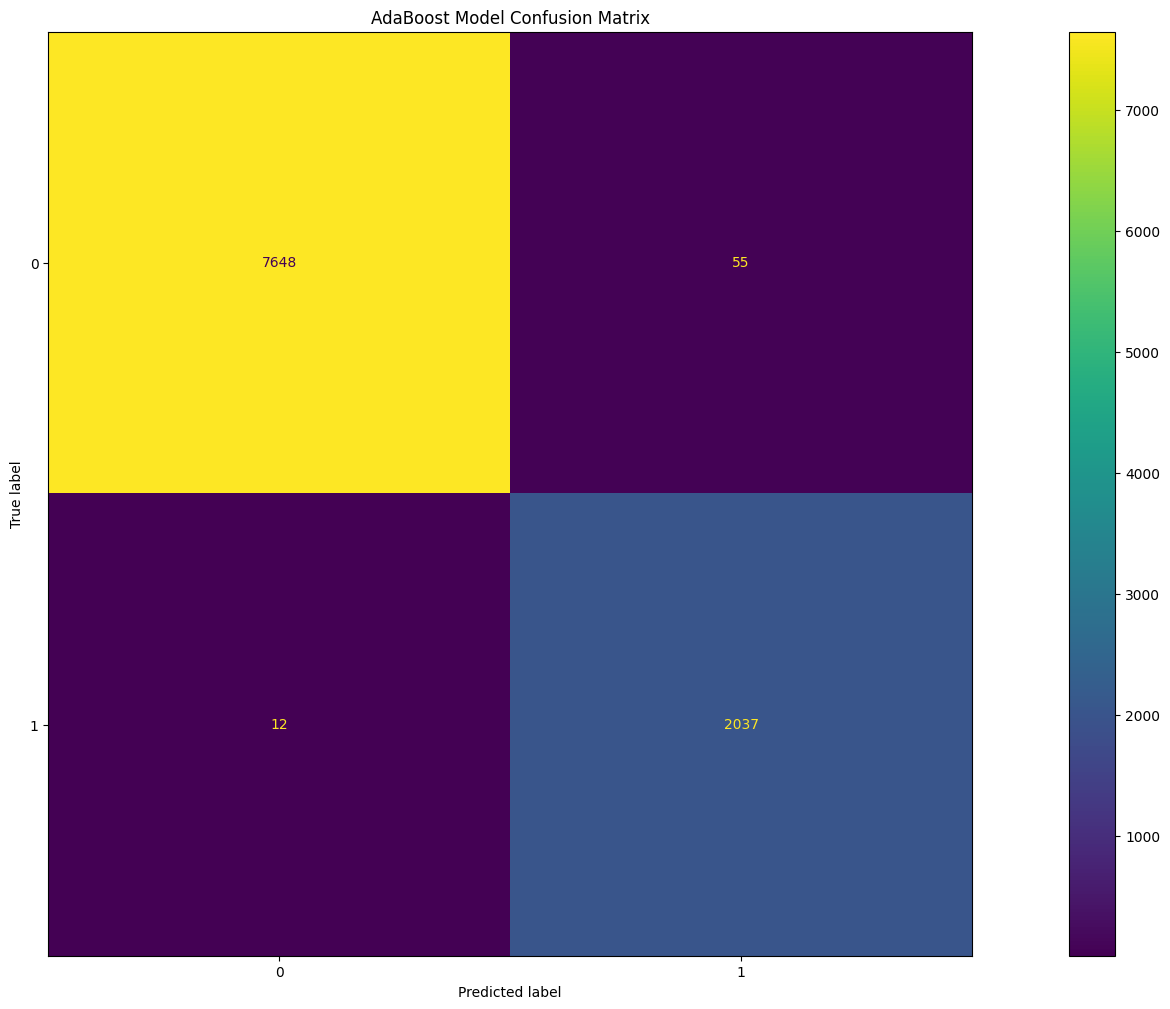

In [ ]:
#Displaying the Confusion Matrix
cm_Adaboost = confusion_matrix(y_test, Ada_pred, labels=Ada_clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_Adaboost,
                              display_labels=Ada_clf.classes_)

#Disable interactive mode to prevent shaking
plt.ioff()
# Create a new figure with a specific size (you can adjust width and height as needed)
disp.plot()
# Add a title to the plot
plt.title('AdaBoost Model Confusion Matrix')
# Show the plot
plt.show()

### Future Scope
1- Implementing  deep learning models to predict the office room occupancy

2- Generalizing the best model with more ambient features to not only office rooms, but other types of rooms in houses, hospitals, and shopping malls

3- Conducting time series analysis on continuous features such as CO2 and Light to extract trends.

### Conclusion
In this project, I tried to build predictive models with high accuracy and high precision at the same time to predict the room occupancy of an office room based on different ambient features. I observed despite the multicollinearity between the features, using proper scalings such as a standard scaler, distance-based methods such as logistic regression and the support vector classifier yielded high accuracy and high precision. On the other hand, the accuracy of all ensemble methods was greater than 95%. The first intuition expected the Xgboost classifier to have the highest accuracy and precision on the test dataset, but the Adaboost had the highest accuracy (99.31%) and the highest precision (97.37%) among all models in this project. Furthermore, the size of the test data set was relatively larger than the training dataset with 9752 records. Having such a high accuracy and precision on the test set indicates that the model suggests low bias and low variance and can be generalized to other test sets.

Furthermore, The result of the Adaboost model indicates how important the feature selection is. Feature selection and preprocessing steps should be in accordance with the type of ML model. Having said this, in the Adaboost model, the most important feature was Light, and the structure of the stumps allowed us to take advantage of this feature at the highest possible without needing other features. Creating multiple models together will allow us to understand the importance of each feature and use each one or a combination of them in the most efficient and useful form to increase any model metric such as accuracy and precision.

### References

1.UCI Machine Learning Repository. (n.d.). Archive.ics.uci.edu. Retrieved July 21, 2023, from https://archive.ics.uci.edu/dataset/357/occupancy+detection

2.scikit-learn. (2019). scikit-learn: machine learning in Python. Scikit-Learn.org. https://scikit-learn.org/stable/

3.Horsch, A. (2021, December 21). Detecting And Treating Outliers In Python — Part 1. Medium. https://towardsdatascience.com/detecting-and-treating-outliers-in-python-part-1-4ece5098b755

‌4.Detecting Multicollinearity with VIF - Python. (2020, August 14). GeeksforGeeks. https://www.geeksforgeeks.org/detecting-multicollinearity-with-vif-python/

‌5.Candanedo,Luis. (2016). Occupancy Detection . UCI Machine Learning Repository. https://doi.org/10.24432/C5X01N.

6.Python API Reference — xgboost 1.5.0 documentation. (2021). Readthedocs.io. https://xgboost.readthedocs.io/en/stable/python/python_api.html

‌7.Feature importances with a forest of trees. (n.d.). Scikit-Learn. https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html